## Demonstrate fitting a torchani model

In [1]:
from glob import glob

import torch
import numpy as np
import pandas as pd
from ase.io import read
import seaborn as sns
import matplotlib.pyplot as plt

# our methods for quickly making ani nets
from cascade.learning.torchani import TorchANI, estimate_atomic_energies
from cascade.learning.torchani.build import make_aev_computer, make_output_nets

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


## Config

In [2]:
# use cuda if its available
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'
device

'cuda:0'

## Read in Data

We'll train based on the trajectories we've generated earlier

In [3]:
trajectories = glob('../0_setup/md/**/md.traj')
trajectories

['../0_setup/md/packmol-CH4-in-H2O=32-seed=0-blyp-npt=298/md.traj',
 '../0_setup/md/packmol-CH4-in-H2O=32-seed=2-blyp-npt=298/md.traj',
 '../0_setup/md/packmol-CH4-in-H2O=32-seed=1-blyp-npt=298/md.traj',
 '../0_setup/md/packmol-CH4-in-H2O=32-seed=3-blyp-npt=298/md.traj']

Since we have 4 trajectories, we'll train on the first two, validate on the third, and test on the last

In [4]:
train = []
for traj in trajectories[:-2]: 
    train.extend(read(traj, index=':'))

In [5]:
valid = read(trajectories[2], index=':')
test = read(trajectories[3], index=':')

## Build the ANI net

These methods contruct a network with sensible default hyperaarameters. 

In [6]:
ref_energies = estimate_atomic_energies(train)
species = list(ref_energies.keys())
aev = make_aev_computer(species)
nn = make_output_nets(species, aev)

And the below is a class that handles training and evaluation given the above data parameters.   
The reason these methods are decoupled from the parameters is so we can easily pass the parameters around in a distributed computing setting. 

In [7]:
ani = TorchANI()

In [8]:
%%time
orig_e, orig_f = ani.evaluate((aev, nn, ref_energies), 
                              train,
                              #batch_size=,
                              device=device)

CPU times: user 3.2 s, sys: 340 ms, total: 3.55 s
Wall time: 3.55 s


In [9]:
%%time
model_msg, results = ani.train((aev, nn, ref_energies), 
                               train, 
                               valid, 
                               30,
                               #learning_rate=0.0001,
                               device=device)

CPU times: user 5min 22s, sys: 686 ms, total: 5min 22s
Wall time: 5min 23s


The trainer returns a dataframe of performance for each epoch

In [10]:
results.head()

,iteration,e_rmse,e_mae,f_rmse,f_mae,split
0,0,1.003936,1.003936,0.482978,0.482978,train
1,1,0.242016,0.242016,0.442315,0.442315,train
2,2,1.200089,1.200089,0.397986,0.397986,train
3,3,0.946980,0.946980,0.375883,0.375883,train
4,4,4.304349,4.304349,0.345489,0.345489,train


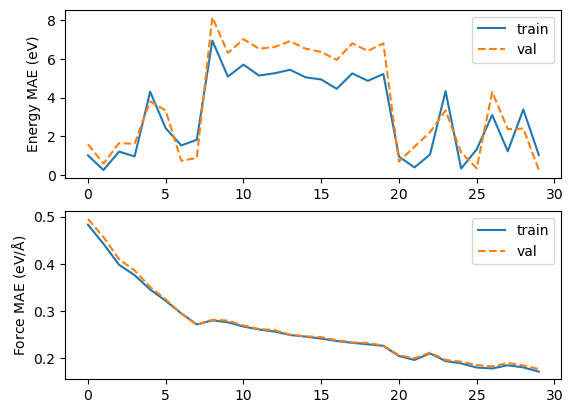

In [11]:
fig, axs = plt.subplots(2)

for split, marker, linestyle in zip(['train', 'val'], 
                                    ['x', 'o'], 
                                    ['solid', 'dashed']):
    for i, quantity in enumerate(['e_mae', 'f_mae']):
        _df = results.query(f'split == "{split}"')
        axs[i].plot(_df['iteration'], 
                    _df[quantity], 
                    label=split, 
                    #marker=marker,
                    linestyle=linestyle
                   )

axs[0].set_ylabel('Energy MAE (eV)')
axs[0].legend()
axs[1].set_ylabel('Force MAE (eV/$\mathrm{\AA})$')
axs[1].legend()

We see there is some generalization gap, moreso with the energy. I think some hyperparameters, including the learning rate, need tuning, but this is a good start. 

## Evaluate on test trajectory
We'll quickly get the test trajectory errors

In [12]:
energy_test_true = np.asarray([a.calc.results['energy'] for a in test])
forces_test_true = np.asarray([a.calc.results['forces'] for a in test])

In [13]:
energy_test_pred, forces_test_pred = ani.evaluate(
    (aev, nn, ref_energies), 
    test,
    device=device)

In [14]:
print(f'Energy MAE: {np.abs((energy_test_pred-energy_test_true)).mean():0.5f} eV')

Energy MAE: 1.51917 eV


In [15]:
print(f'Force MAE: {np.abs((forces_test_pred-forces_test_true)).mean():0.5f} eV/Angstrom')

Force MAE: 0.18799 eV/Angstrom
